# Testing Simple Nasdaq Momentum Strategy

The idea is to construct the following portfolio each month: 

(1) Select 50 best performing stocks out of those in Nasdaq based on 12 months pct. change
(2) From (1) select the 30 best performing based on 6 months pct. change
(3) From (2) select top 10 based on 3 months pct. change

In [74]:
# Importing useful libraries

import pandas as pd 
import yfinance as yf 
import numpy as np 
import matplotlib.pyplot as plt

# Reading stocks that are in NDX 

pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4].head()

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,ADP,ADP,Information Technology,Data Processing & Outsourced Services
3,Airbnb,ABNB,Consumer Discretionary,Internet & Direct Marketing Retail
4,Align Technology,ALGN,Health Care,Health Care Supplies


In [37]:
# Creating list of tickers

ticker_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
tickers = ticker_df.Ticker.to_list()
tickers[0:5]

['ATVI', 'ADBE', 'ADP', 'ABNB', 'ALGN']

In [38]:
# Downloading data from Yahoo finance API for each ticker to dataframe

df = yf.download(tickers, start="2010-01-01")["Adj Close"]

[*********************100%***********************]  102 of 102 completed


In [39]:
# Checking data 
df.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.515212,NaN,37.090000,23.067619,27.491209,25.670000,21.142136,18.50,11.328531,9.70,...,NaN,18.767342,29.123728,21.007998,44.240002,26.326157,NaN,13.597206,NaN,NaN
2010-01-05,6.526475,NaN,37.700001,23.031202,27.343584,25.280001,20.900099,18.01,11.241385,9.71,...,NaN,18.659109,29.318857,21.228777,42.779999,26.114428,NaN,13.435949,NaN,NaN
2010-01-06,6.422665,NaN,37.619999,22.987501,27.279387,25.340000,21.111881,17.48,11.217621,9.57,...,NaN,18.522011,29.699369,20.999506,42.029999,25.916805,NaN,13.461750,NaN,NaN
2010-01-07,6.410791,NaN,36.889999,22.805407,27.266560,25.480000,21.293415,17.43,11.098791,9.47,...,NaN,18.579739,29.650583,20.710794,41.500000,26.072073,NaN,13.403695,NaN,NaN
2010-01-08,6.453413,NaN,36.689999,22.936510,27.228045,26.260000,21.547558,17.66,11.526580,9.43,...,NaN,19.005445,29.270075,20.872133,40.669998,26.107363,NaN,13.410148,NaN,NaN


In [40]:
# Cleaning NaN rows 

df = df.dropna(axis=1)

In [41]:
# Getting monthly pct. changes to df 

monthly_returns =  (df.pct_change()+1)[1:].resample("M").prod()

In [42]:
# To do our selection we define a function that calculates-
# the monthly rolling return which we need for intervals 3,6,12

def rolling_return(df, n): 
    return df.rolling(n).apply(np.prod)

r_3 = rolling_return(monthly_returns, 3)
r_6 = rolling_return(monthly_returns, 6)
r_12 = rolling_return(monthly_returns, 12)

In [43]:
# We now write a function to return top performers of a given date

def top_perf(date): 
    top_50 = r_12.loc[date].nlargest(50).index 
    top_30 = r_6.loc[date].nlargest(30).index 
    top_10 = r_3.loc[date].nlargest(10).index
    return top_10

In [54]:
# And to test we need the actual portfolio performance (we use mean allocation#)

def performance(date): 
    portfolio = monthly_returns.loc[date:, top_perf(date)][1:2]
    return portfolio.mean(axis=1).values[0]

Text(0, 0.5, 'Wealth Factor Index=1')

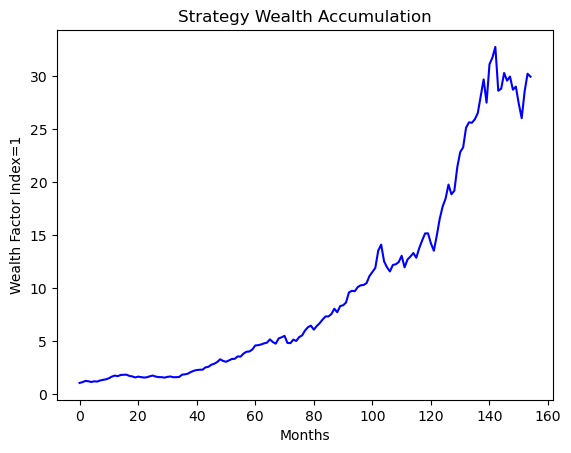

In [109]:
# Getting returns for each month utilizing the strategy

returns = []

for date in monthly_returns.index[:-1]: 
    returns.append(performance(date))

# Getting data to series and plotting the cumulative product
    
pd.Series(returns).cumprod().plot(color="Blue")
plt.title("Strategy Wealth Accumulation")
plt.xlabel("Months")
plt.ylabel("Wealth Factor Index=1")

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

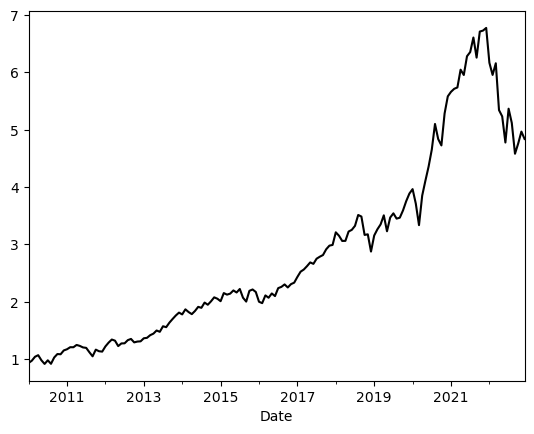

In [124]:
# We also need to see it plotted against Nasdaq itself 

ndx = yf.download("^IXIC", start="2010-01-01")

ndx = (ndx.pct_change()+1)[1:].resample("M").prod()

ndx_returns = ndx["Adj Close"]

pd.Series(ndx_returns).cumprod().plot(color="Black")

In [125]:
# And as we can see, the strategy significantly outperforms just owning Nasdaq. Which is quite suprising. 

Note that this analysis does not take into account transaction costs. 